# TFM: Xarxes de col·laboració en estudis clínics sobre càncer de mama 
# Alumne: Maria Font Sánchez

## Fase 3: Preparació de les dades

La preparació de les dades consisteix en 3 passes:

1. La **descàrrega** dels fitxers de clinicaltrials.gov i el filtratge i **selecció** dels estudis clínics relacionats amb el càncer de mama. Aquí, també s'inclou l'estudi estadístic descriptiu per a entendre quins estudis s'han seleccionat.

2. La **transformació** dels fitxers XML a RDF, seguint la estructura definida per la ontologia [OCRe](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4019723/). En aquest procés de transformació, també es realitza una normalització de les dades (minúscules, passant a dades categòriques, etc.), i una posterior inserció del resultat a la base de dades NoSQL, en aquest cas [GraphDB](https://www.ontotext.com/).

3. **Implementació** i estructuració de les dades per a ser utilitzar per al model que es desenvolupa en la Fase 4.

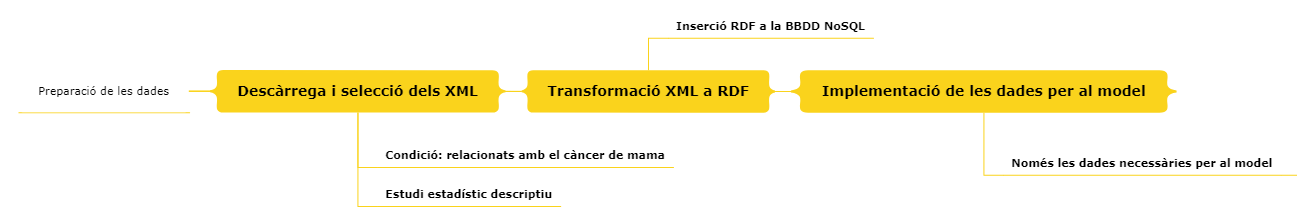

A continuació es mostren les llibreries que s'utilitzen per a la execució d'aquest Notebook:

In [1]:
# Llibreries
import csv
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile

### 1. Descàrrega dels XML

<div class="alert alert-block alert-warning">
Les passes "1. Descàrrega dels XML" i "2. Selecció dels estudis clínics sobre el càncer de mama" es poden saltar descarregant-se els fitxers XML sobre el càncer de mama del següent <a href="https://drive.google.com/file/d/1wcqgR36cBNBrCqwOn-Jx0JmoOFjx1gvR/view?usp=share_link">enllaç</a>. 
    <br><br>Cal descomprimir els fitxers i guardar-los en la carpeta que es troba definia en la variable: PATH_DESTINATION.
</div>

Descàrrega del fitxer ZIP de la web de [clinicaltrials.gov](https://clinicaltrials.gov/api/gui/ref/download_all) i el posterior unzip del fitxer.
<br><br>Primerament, es definiran les rutes on es guardarà el fitxer ZIP i els XMLs.

In [2]:
PATH_ZIP = "../../content/clinical_trials_xml.zip"
PATH_XMLS = "../../content/clinicaltrials_all"

In [5]:
# Descàrrega del fitxer ZIP
CLINICAL_TRIALS_XML = "https://ClinicalTrials.gov/AllAPIXML.zip"

r = requests.get(CLINICAL_TRIALS_XML, allow_redirects=True)
open(PATH_ZIP, 'wb').write(r.content)

2468092862

In [4]:
# Unzip del fitxer
with ZipFile(PATH_ZIP, 'r') as zipfile:
    zipfile.extractall(path=PATH_XMLS)

<div class="alert alert-block alert-info">
El dia de la descàrrega d'aquest fitxer, hi havia un total de 443,933 estudis en format XML, publicats a data de l'1 de Març del 2023.
</div>

### 2. Selecció dels estudis clínics sobre el càncer de mama

Els estudis clínics sobre el càncer de mama contenen en l'element *condition* les paraules *Breast Cancer*. Aquest element es troba en el següent camí dins del XML:
* /Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ConditionsModule']/List[@Name='ConditionList']/Field[@Name='Condition']

In [8]:
# Variables globals

# Carpeta destí on es guardaran els XML filtrats.
PATH_DESTINATION = "../../content/clinicaltrials_breastcancer"

# Element i nom per a filtrar els XMLs.
FILTER_CONDITION = "breast cancer"
XML_PATH_CONDITION = "./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ConditionsModule']/List[@Name='ConditionList']/Field[@Name='Condition']"

Els documents XML es troben dins de múltiples carpetes, separats en 10,000 fitxers per carpeta, segons el seu número d'identificació.

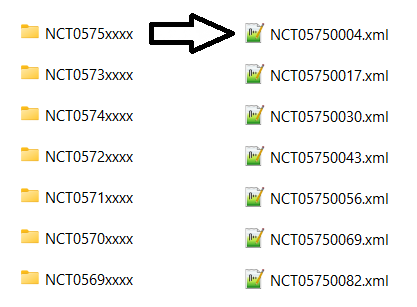

S'han definit dues funcions per tal de llegir tots els XML, filtrar-los i guardar-los en la carpeta destí definida en la variable *PATH_DESTINATION*.

In [24]:
def get_list_files(path:str):
    """ Mètode per a obtenir el llistat de fitxers d'una o vàries carpetes. 

    Parameters:
        path (str):Ruta on extreure els fitxers.

    Returns:
        None   
    """

    dir_list = os.listdir(path)

    for folder in dir_list:
        folder_path = path +"/"+ folder
        if not os.path.isfile(folder_path):
            # Si l'objecte és una carpeta, es fa una crida recursiva.
            get_list_files(folder_path)
        else:
            # Si l'objecte és un fitxer, es crida la funció de filtratge.
            filter_condition(folder_path, folder)
            
            
def filter_condition(xml:str, file_name:str):
    """ Mètode per a filtrar els XML segons la condició definida en la variable FILTER_CONDITION, 
    i guardat el XML a la carpeta PATH_DESTINATION. 

    Parameters:
        xml (str):Ruta absoluta del XML.
        file_name (str):Nom del fitxer

    Returns:
        None   
    
    """
    
    try:
        tree = ET.parse(xml)
        root = tree.getroot()

        for xml_condition in root.findall(XML_PATH_CONDITION):
            if FILTER_CONDITION == xml_condition.text.lower():
                # Si el XML compleix la condició, es guarda el XML en una altra carpeta.
                shutil.copyfile(xml, PATH_DESTINATION + "/" + file_name)
                
    except Exception as ex:
        pass

In [25]:
# Crida del filtratge.        
get_list_files(PATH_XMLS)

<div class="alert alert-block alert-info">
Amb les dades descarregades anteriorment, hi ha un total de 10,055 fiters XML sobre els estudis clínics relacionats amb el càncer de mama.
</div>

### 3. Estudi estadístic descriptiu

L'estudi estadístic descriptiu ha de permetre visualitzar si les dades obtingudes de les fonts de dades estan complertes, què cal normalitzar (si es necessari), i entendre d'una forma global quina informació hi ha.

<br><br>El primer que cal fer és definir les rutes on es guardaran els fitxers CSV, i posteriorment és realitzarà la lectura de les dades i s'emmagatzemaran en un fitxer CSV per agilitzar el l'estudi estadístic.

<div class="alert alert-block alert-warning">
En la carpeta descarregada del GitHub, ja es troben els CSV per a poder realitzar l'estudi estadístic descriptiu. Per tant, si es desitja, es pot accedir directament a la lectura del fitxer. 
</div>

In [5]:
# Variables globals
PATH_DATA_STATISTICAL_STUDY = '../../content/statistics/dades_clinicaltrials.csv'
PATH_COLLAB_STATISTICAL_STUDY = '../../content/statistics/dades_collaboradors_clinicaltrials.csv'

In [72]:
dict_dades = []
dict_collabs = []

def get_specific_xml_data():
    """ Mètode general per a la lectura dels fitxers XML i posterior escriptura en els fitxers CSV. 
    Es creen dos fitxers, un per les dades dels estudis clínics i l'altre per a les dades relacionades amb els col·laboradors.

    Parameters:
        None

    Returns:
        None   
    """
    
    files_list = os.listdir(PATH_DESTINATION)

    for file in files_list:
        folder_path = PATH_DESTINATION +"/"+ file
        if os.path.isfile(folder_path):
            # Per a cada XML, s'estreuen les dades generals i dels col·laboradors
            get_xml_data(folder_path)
            get_collaborator_data(folder_path)
        
    # Es guarda en un CSV les dades dels estudis clínics
    with open(PATH_DATA_STATISTICAL_STUDY, 'w', newline='', encoding="utf-8") as f:
        w = csv.writer(f, delimiter=';')
        w.writerow(['NCTId', 'StartDate', 'OverallStatus', 'CompletionDate', 
                    "Condition", "MeshCondition", "Intervention", "MeshIntervention", "StudyType",
                    "Phase", "DesignModel", "InterventionType", "LeadSponsorName", "LeadSponsorClass", ])
        
        for dictionary in dict_dades:
            try:
                w.writerow(dictionary.values())
            except Exception as ex:
                print ("Error: ",ex)
                print(dictionary.values())
        
    # Es guarda en un CSV les dades dels col·laboradors dels estudis clínics
    with open(PATH_COLLAB_STATISTICAL_STUDY, 
              'w', newline='', encoding="utf-8") as f:
        w = csv.writer(f, delimiter=';')
        w.writerow(['NCTId', "LeadSponsorName", "LeadSponsorClass", "CollaboratorName", "CollaboratorClass", 
                    "Condition", "StudyType", "OverallOfficialName", "OverallOfficialAffiliation", "OverallOfficialRole",
                    "ResponsiblePartyType", "ResponsiblePartyInvestigatorFullName", "ResponsiblePartyInvestigatorAffiliation",
                    "ResponsiblePartyInvestigatorTitle", ])
        for dictionary in dict_collabs:
            try:
                w.writerow(dictionary.values())
            except Exception as ex:
                print ("Error: ",ex)
                print(dictionary.values())

            
def get_xml_data(xml_path:str):
    """ Mètode de lectura dels fitxers XML sobre el càncer de mama i guardar de les dades seleccionades en un diccionari.

    Parameters:
        xml_path (str):Ruta on es troba l'XML.

    Returns:
        None   
    """
    
    try:
        dades = {'NCTId': None, "StartDate": None, "OverallStatus": None, "CompletionDate": None, 
                 "Condition": None, "MeshCondition": None, "Intervention": None,
                 "MeshIntervention": None, "StudyType": None, "Phase": None, "DesignModel": None, "InterventionType": None,
                 "LeadSponsorName": None, "LeadSponsorClass": None
                }
        
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='IdentificationModule']/Field[@Name='NCTId']"):
            dades["NCTId"] = attr.text
            
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='StatusModule']/Struct[@Name='StartDateStruct']/Field[@Name='StartDate']"):
            dades["StartDate"] = attr.text
        
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='StatusModule']/Field[@Name='OverallStatus']"):
            dades["OverallStatus"] = attr.text
        
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='StatusModule']/Struct[@Name='CompletionDateStruct']/Field[@Name='CompletionDate']"):
            dades["CompletionDate"] = attr.text
                                    
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ConditionsModule']/List[@Name='ConditionList']"):
            condition = []
            
            for attr2 in attr.findall("./Field[@Name='Condition']"):
                condition.append(attr2.text) 
            
            dades["Condition"] = condition
        
        condition_taxonomy = []
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='DerivedSection']/Struct[@Name='ConditionBrowseModule']/List[@Name='ConditionBrowseLeafList']/Struct[@Name='ConditionBrowseLeaf']/Field[@Name='ConditionBrowseLeafName']"):
            condition_taxonomy.append(attr.text)
        
        dades["MeshCondition"] = condition_taxonomy
        
        intervention = []
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ArmsInterventionsModule']/List[@Name='InterventionList']/Struct[@Name='Intervention']/Field[@Name='InterventionName']"):
            intervention.append(attr.text)
            
        dades["Intervention"] = intervention
        
        intervention_taxonomy = []
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='DerivedSection']/Struct[@Name='InterventionBrowseModule']/List[@Name='InterventionBrowseLeafList']/Struct[@Name='InterventionBrowseLeaf']/Field[@Name='InterventionBrowseLeafName']"):
            intervention_taxonomy.append(attr.text)
            
        dades["MeshIntervention"] = intervention_taxonomy
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='DesignModule']/Field[@Name='StudyType']"):
            dades["StudyType"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='DesignModule']/List[@Name='PhaseList']"):
            phase = []
            
            for attr2 in attr.findall("./Field[@Name='Phase']"):
                phase.append(attr2.text) 
            
            dades["Phase"] = phase
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='DesignModule']/Struct[@Name='DesignInfo']/List[@Name='DesignPrimaryPurpose']"):
            dades["DesignModel"] = attr.text
        
        design = []    
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='DesignModule']/Struct[@Name='DesignInfo']/List[@Name='DesignObservationalModelList']/Field[@Name='DesignObservationalModel']"):
            design.append(attr.text)
        
        if len(design) > 0:
            dades["DesignModel"] = design
              
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ArmsInterventionsModule']/List[@Name='InterventionList']"):
            intervention = []
            
            for attr2 in attr.findall("./Struct[@Name='Intervention']/Field[@Name='InterventionType']"):
                intervention.append(attr2.text) 
            
            dades["InterventionType"] = list(set(intervention))
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='LeadSponsor']/Field[@Name='LeadSponsorName']"):
            dades["LeadSponsorName"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='LeadSponsor']/Field[@Name='LeadSponsorClass']"):
            dades["LeadSponsorClass"] = attr.text
            
        dict_dades.append(dades)
                
    except Exception as ex:
        print(xml_path)
        print(ex)
        pass

    

def get_collaborator_data(xml_path:str):
    """ Mètode de lectura dels fitxers XML sobre el càncer de mama i 
    guardar de les dades relacionades amb els col·laboradors en un diccionari.

    Parameters:
        xml_path (str):Ruta on es troba l'XML.

    Returns:
        None   
    """
    
    try:
        dades = {'NCTId': None, "LeadSponsorName": None, "LeadSponsorClass": None, 
                 "CollaboratorName": None, "CollaboratorClass": None, "Condition": None, "StudyType": None,
                 'OverallOfficialName': None, 'OverallOfficialAffiliation': None, 'OverallOfficialRole': None,
                 "ResponsiblePartyType": None, "ResponsiblePartyInvestigatorFullName": None, 
                 "ResponsiblePartyInvestigatorAffiliation": None, "ResponsiblePartyInvestigatorTitle": None 
                }
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='IdentificationModule']/Field[@Name='NCTId']"):
            dades["NCTId"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='LeadSponsor']/Field[@Name='LeadSponsorName']"):
            dades["LeadSponsorName"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='LeadSponsor']/Field[@Name='LeadSponsorClass']"):
            dades["LeadSponsorClass"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/List[@Name='CollaboratorList']/Struct[@Name='Collaborator']"):
            collabnames = []
            collabclass = []
            
            for attr2 in attr.findall("./Field[@Name='CollaboratorName']"):
                collabnames.append(attr2.text)
            for attr2 in attr.findall("./Field[@Name='CollaboratorClass']"):
                collabclass.append(attr2.text)
                
            dades["CollaboratorName"] = collabnames
            dades["CollaboratorClass"] = collabclass
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='ResponsibleParty']/Field[@Name='ResponsiblePartyType']"):
            dades["ResponsiblePartyType"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='ResponsibleParty']/Field[@Name='ResponsiblePartyInvestigatorFullName']"):
            dades["ResponsiblePartyInvestigatorFullName"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='ResponsibleParty']/Field[@Name='ResponsiblePartyInvestigatorTitle']"):
            dades["ResponsiblePartyInvestigatorTitle"] = attr.text
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='SponsorCollaboratorsModule']/Struct[@Name='ResponsibleParty']/Field[@Name='ResponsiblePartyInvestigatorAffiliation']"):
            dades["ResponsiblePartyInvestigatorAffiliation"] = attr.text
                                    
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ConditionsModule']/List[@Name='ConditionList']"):
            condition = []
            
            for attr2 in attr.findall("./Field[@Name='Condition']"):
                condition.append(attr2.text) 
            
            dades["Condition"] = condition
                  
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='DesignModule']/Field[@Name='StudyType']"):
            dades["StudyType"] = attr.text
        
        for attr in root.findall("./Struct[@Name='Study']/Struct[@Name='ProtocolSection']/Struct[@Name='ContactsLocationsModule']/List[@Name='OverallOfficialList']/Struct[@Name='OverallOfficial']"):
            official = dades.copy()
            
            for attr2 in attr.findall("./Field[@Name='OverallOfficialName']"):
                official['OverallOfficialName'] = attr2.text
            
            for attr2 in attr.findall("./Field[@Name='OverallOfficialAffiliation']"):
                official['OverallOfficialAffiliation'] = attr2.text
            
            for attr2 in attr.findall("./Field[@Name='OverallOfficialRole']"):
                official['OverallOfficialRole'] = attr2.text
            
            dict_collabs.append(official)
            
    except Exception as ex:
        print(ex)
        print(xml_path)
        pass

    
get_specific_xml_data()

Inici de l'estudi estadístic de les dades dels estudis clínics filtrats, començant amb les dades que no són els col·laboradors:

In [6]:
df = pd.read_csv(PATH_DATA_STATISTICAL_STUDY, sep=';')
df.head()

,NCTId,StartDate,OverallStatus,CompletionDate,Condition,MeshCondition,Intervention,MeshIntervention,StudyType,Phase,DesignModel,InterventionType,LeadSponsorName,LeadSponsorClass
0,NCT00001239,July 1989,Completed,January 2001,"['Breast Cancer', 'Breast Neoplasms']","['Carcinoma', 'Breast Neoplasms', 'Breast Dise...",['FLAC with GM-CSF'],"['Leucovorin', 'Fluorouracil', 'Sargramostim',...",Interventional,['Phase 2'],NaN,['Drug'],National Cancer Institute (NCI),NIH
1,NCT00001302,September 1992,Completed,June 2002,"['Breast Cancer', 'Kidney Neoplasm', 'Lymphoma...","['Ovarian Neoplasms', 'Lymphoma', 'Breast Neop...",['PSC 833'],"['Cyclosporine', 'Cyclosporins', 'Vinblastine'...",Interventional,['Phase 1'],NaN,['Drug'],National Cancer Institute (NCI),NIH
2,NCT00001378,January 1994,Completed,November 2000,"['Breast Cancer', 'Breast Neoplasms']","['Breast Neoplasms', 'Breast Diseases', 'Skin ...",['fenretinide'],"['Tamoxifen', 'Fenretinide', 'Retinamide', 'Pr...",Interventional,['Phase 1'],NaN,['Drug'],National Cancer Institute (NCI),NIH
3,NCT00001383,March 1994,Completed,January 2001,"['Breast Cancer', 'Cancer', 'Carcinoma, Renal ...","['Ovarian Neoplasms', 'Carcinoma', 'Lymphoma',...","['PSC 833', 'paclitaxel']","['Paclitaxel', 'Albumin-Bound Paclitaxel', 'Cy...",Interventional,['Phase 1'],NaN,['Drug'],National Cancer Institute (NCI),NIH
4,NCT00001384,May 1994,Completed,February 2001,"['Breast Cancer', 'Breast Neoplasms']","['Breast Neoplasms', 'Breast Diseases', 'Skin ...","['Adriamycin', 'cyclophosphamide', 'G-CSF', 'p...","['Paclitaxel', 'Cyclophosphamide', 'Albumin-Bo...",Interventional,['Phase 2'],NaN,['Drug'],National Cancer Institute (NCI),NIH


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10055 entries, 0 to 10054
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   NCTId             10055 non-null  object
 1   StartDate         9994 non-null   object
 2   OverallStatus     10055 non-null  object
 3   CompletionDate    9523 non-null   object
 4   Condition         10055 non-null  object
 5   MeshCondition     10055 non-null  object
 6   MeshIntervention  10055 non-null  object
 7   StudyType         10055 non-null  object
 8   Phase             8002 non-null   object
 9   DesignModel       1912 non-null   object
 10  InterventionType  9239 non-null   object
 11  LeadSponsorName   10055 non-null  object
 12  LeadSponsorClass  10055 non-null  object
dtypes: object(13)
memory usage: 1021.3+ KB


In [74]:
df['StartDate'] = pd.to_datetime(df['StartDate'])

Text(0.5, 1.0, 'Estudis clínics per any')

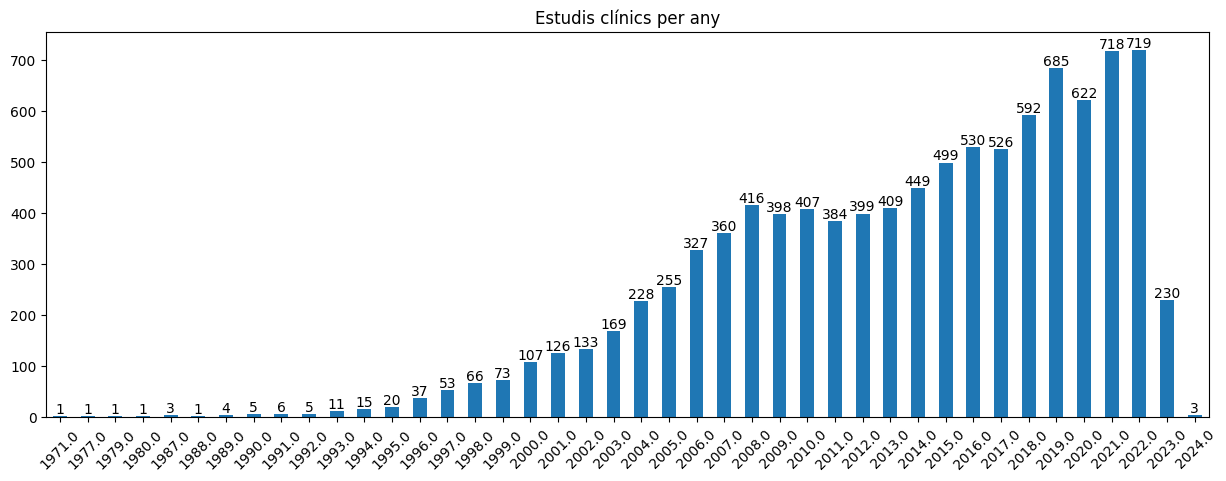

In [67]:
plt.figure(figsize=(15, 5))

ax3 = pd.value_counts(df["StartDate"].dt.year).sort_index().plot.bar(rot=45, grid=False)
ax3.bar_label(ax3.containers[0])
ax3.set_title("Estudis clínics per any")

<div class="alert alert-block alert-info">
Els darrers 20 anys hi ha un creixement exponencial dels estudis clínics sobre el càncer de mama. Tot i que en aquest dataset s'incloguin estudis d'abans dels 2000, és important tenir-los en compte per a la xarxa de col·laboradors, ja que ha pogut haver un avenç derivat de l'estudi.
</div>

Text(0.5, 1.0, 'Estudis clínics any 2023 mes febrer: total 68')

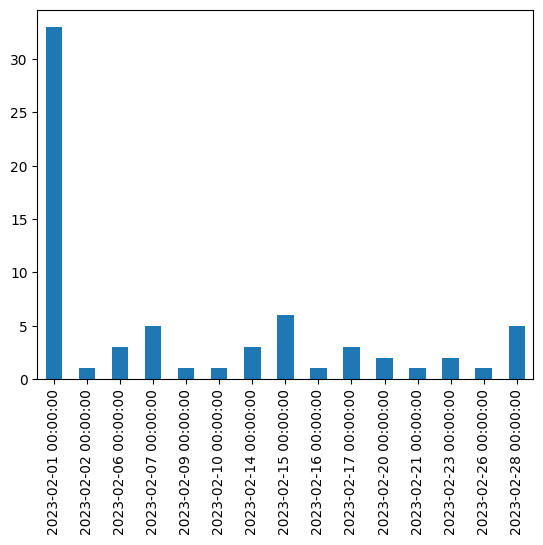

In [68]:
df_year = df[df["StartDate"].dt.year == 2023]
df_month = df_year[df_year["StartDate"].dt.month == 2]

pd.value_counts(df_month["StartDate"]).sort_index().plot.bar(rot=90, grid=False)
ax3.bar_label(ax3.containers[0])

mean_month = round(sum(pd.value_counts(df_month["StartDate"]))/28)
total = sum(pd.value_counts(df_month["StartDate"]))

title = f"Estudis clínics any 2023 mes febrer: total {total}"
ax3.set_title(title)

<div class="alert alert-block alert-info">
La mitjana del mes de febrer de l'any 2023 és de l'inici de 2 estudis clínics per dia, d'un total de 68. Per tant, la xarxa de col·laboradors ha de ser dinàmica en el temps.
</div>

In [160]:
def get_occurrences_list(column_name: str):
    """ Mètode que retorna el llistat d'ocurrències d'una columna del tipus llista.

    Parameters:
        column_name (str):Nom de la columna dins del dataframe.

    Returns:
        list:Llista de keywords i el nombre d'ocurrències.   
    """
    mesh_taxonomy = df[column_name]
    
    list_taxonomy = get_list_items(mesh_taxonomy)
    all_taxonomy_keywords = [item.lower() for sublist in list_taxonomy for item in sublist 
                             if item.lower() != 'nan' and item.lower() != '']

    return pd.value_counts(all_taxonomy_keywords)


def get_list_items(items_list: str):
    """ Mètode que retorna el llistat d'ítems d'un llistat en format text.

    Parameters:
        items_list (str):Llistat d'ítems en text.

    Returns:
        list:Llista d'ítems.
    """
    
    return [list(set(str(x).replace('[', '').replace(']', '').replace('\'', '').split(', '))) for x in items_list]

Text(0.5, 1.0, 'Estudis clínics per paraula clau en la taxonomia Mesh en les condicions')

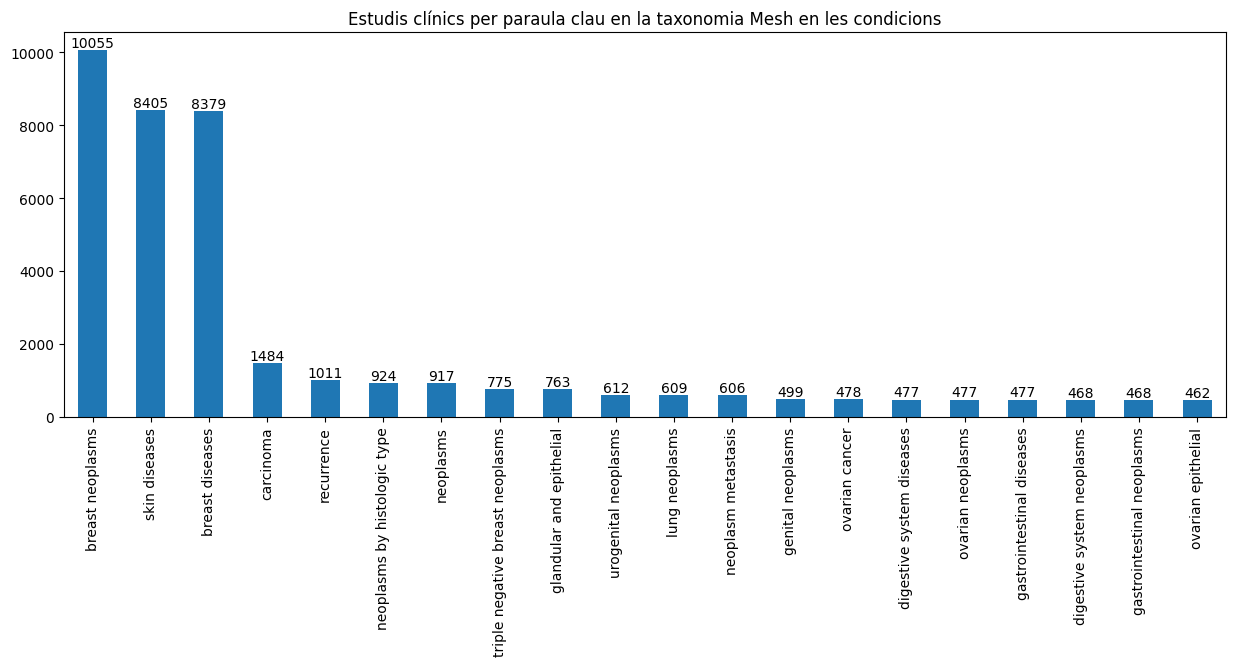

In [114]:
occurrences_keyword = get_occurrences_list("MeshCondition")
plt.figure(figsize=(15, 5))

ax3 = occurrences_keyword.head(20).plot.bar(rot=90, grid=False)
ax3.bar_label(ax3.containers[0])
ax3.set_title("Estudis clínics per paraula clau en la taxonomia Mesh en les condicions")

Text(0.5, 1.0, 'Estudis clínics per paraula clau en la taxonomia Mesh en les intervencions')

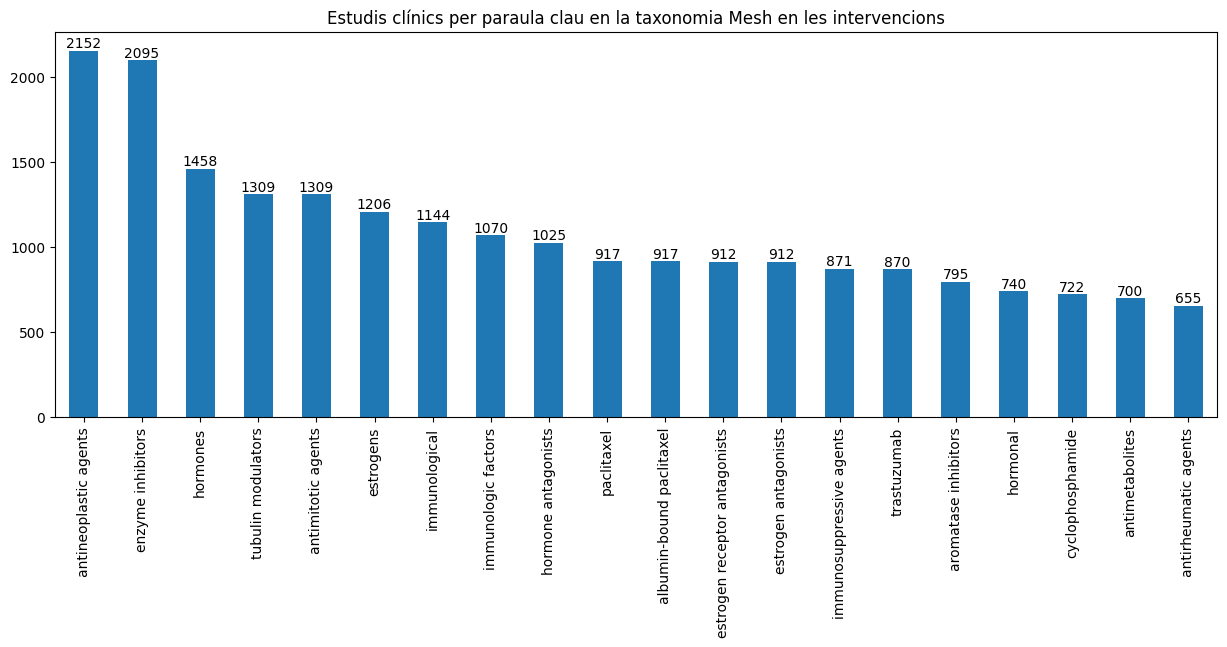

In [71]:
occurrences_keyword = get_occurrences_list("MeshIntervention")
plt.figure(figsize=(15, 5))

ax3 = occurrences_keyword.head(20).plot.bar(rot=90, grid=False)
ax3.bar_label(ax3.containers[0])
ax3.set_title("Estudis clínics per paraula clau en la taxonomia Mesh en les intervencions")

<div class="alert alert-block alert-info">
Tots els estudis clínics tenen la condició de 'Breast Neoplasm', això és degut a que 'Breast Cancer' i 'Breast Neoplasm' són sinònims. Per tant, cal tenir-ho present en el model, ja que pot donar resultats equivocats.
    <br><br>D'altra banda, les condicions de 'skin diseases' i 'breast diseases' també són molt presents en la gran majoria dels estudis clínics. I com amb l'anterior condició, podria esbiaixar els resultats.
    <br><br>Pel que fa a les intervencions, les intervencions dins els estudis clínics està més equilibrat.
</div>

In [141]:
mesh_condition = df["MeshCondition"]
list_mesh_condition = [list(set(str(x.lower()).replace('[', '').replace(']', '').replace('\'', '').split(', '))) for x in mesh_taxonomy]

condition = df["Condition"]
list_condition = [list(set(str(x.lower()).replace('[', '').replace(']', '').replace('\'', '').split(', '))) for x in condition]

all_equal = 0
non_equal = 0
partially = 0

for i in range(0, len(list_mesh_condition)):
    all_eq = 0
    no_eq = 0
    
    for condition in list_condition[i]:
        condition = condition+"s" if condition == 'breast neoplasm' else condition
        condition = 'breast neoplasms' if condition == 'breast cancer' else condition
        if condition in list_mesh_condition[i]:
            all_eq += 1
        else:
            no_eq += 1
            
    if all_eq == 0 and no_eq>0:
        non_equal += 1
    elif no_eq == 0 and all_eq>0:
        all_equal += 1
    else:
        partially += 1

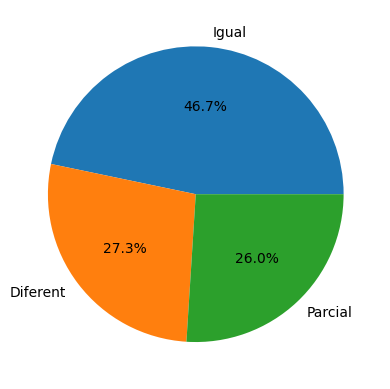

In [142]:
ax = plt.pie([all_equal, non_equal, partially], labels=["Igual", "Diferent", "Parcial"], autopct='%1.1f%%')

<div class="alert alert-block alert-info">
En el gràfic superior, es pot observar que els atributs de Condition i MeshCondition, contenen, en la meitat dels estudis clínics, les mateixes condicions en els dos elements. Cal tenir present que s'han igualat les condicions de 'Breast Cancer' i 'Breast Neoplasm'.
<br><br>L'altre meitat d'estudis clínics, tenen aquests dos atributs parcialment iguals o totalment diferents. Això pot ser degut a que dins l'atribut Condition, s'estan definint les condicions amb més detall, com en el cas d'indicar 'Stage', 'Recurrent', entre d'altres. 
    <br><br>Aquest enriquiment hauria d'afavorir a l'hora de trobar comunitats entre estudis clínics ja que aporta més riquesa en la seva definició.
</div>

In [10]:
df_collab = pd.read_csv(PATH_COLLAB_STATISTICAL_STUDY, sep=';')
df_collab.head()

,NCTId,LeadSponsorName,LeadSponsorClass,CollaboratorName,CollaboratorClass,Condition,StudyType,OverallOfficialName,OverallOfficialAffiliation,OverallOfficialRole,ResponsiblePartyType,ResponsiblePartyInvestigatorFullName,ResponsiblePartyInvestigatorAffiliation,ResponsiblePartyInvestigatorTitle
0,NCT00001503,National Cancer Institute (NCI),NIH,NaN,NaN,"['Melanoma', 'Ovarian Cancer', 'Prostate Cance...",Observational,"James L Gulley, M.D.",National Cancer Institute (NCI),Principal Investigator,Sponsor,NaN,NaN,NaN
1,NCT00001806,National Cancer Institute (NCI),NIH,NaN,NaN,"['Breast Cancer', 'Ovarian Cancer']",Interventional,"Kathleen Calzone, R.N.",National Cancer Institute (NCI),Principal Investigator,Sponsor,NaN,NaN,NaN
2,NCT00002455,Centro Oncologico de Excelencia,OTHER,NaN,NaN,"['Breast Cancer', 'Colorectal Cancer', 'Melano...",Interventional,"Hugo Omar De Carli, MD",Centro Oncologico de Excelencia,Study Chair,NaN,NaN,NaN,NaN
3,NCT00002460,Cancer Research UK,OTHER,NaN,NaN,['Breast Cancer'],Interventional,"Michael Baum, MD, ChM, FRCS",University College London Hospitals,Study Chair,NaN,NaN,NaN,NaN
4,NCT00002465,St. Vincent Medical Center - Los Angeles,OTHER,NaN,NaN,"['Breast Cancer', 'Endometrial Cancer', 'Malig...",Interventional,"Charles L. Wiseman, MD, FACP",NaN,Study Chair,NaN,NaN,NaN,NaN


In [192]:
df_collab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110 entries, 0 to 10109
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   NCTId                                    10110 non-null  object
 1   LeadSponsorName                          10110 non-null  object
 2   LeadSponsorClass                         10110 non-null  object
 3   CollaboratorName                         4604 non-null   object
 4   CollaboratorClass                        4604 non-null   object
 5   Condition                                10110 non-null  object
 6   StudyType                                10110 non-null  object
 7   OverallOfficialName                      10110 non-null  object
 8   OverallOfficialAffiliation               10097 non-null  object
 9   OverallOfficialRole                      10077 non-null  object
 10  ResponsiblePartyType                     9123 non-null   o

In [194]:
df_collab[df_collab['same_responsible']==False].head()

,NCTId,LeadSponsorName,LeadSponsorClass,CollaboratorName,CollaboratorClass,Condition,StudyType,OverallOfficialName,OverallOfficialAffiliation,OverallOfficialRole,ResponsiblePartyType,ResponsiblePartyInvestigatorFullName,ResponsiblePartyInvestigatorAffiliation,ResponsiblePartyInvestigatorTitle,same_responsible
0,NCT00001503,National Cancer Institute (NCI),NIH,NaN,NaN,"['Melanoma', 'Ovarian Cancer', 'Prostate Cance...",Observational,"James L Gulley, M.D.",National Cancer Institute (NCI),Principal Investigator,Sponsor,NaN,NaN,NaN,False
1,NCT00001806,National Cancer Institute (NCI),NIH,NaN,NaN,"['Breast Cancer', 'Ovarian Cancer']",Interventional,"Kathleen Calzone, R.N.",National Cancer Institute (NCI),Principal Investigator,Sponsor,NaN,NaN,NaN,False
2,NCT00002455,Centro Oncologico de Excelencia,OTHER,NaN,NaN,"['Breast Cancer', 'Colorectal Cancer', 'Melano...",Interventional,"Hugo Omar De Carli, MD",Centro Oncologico de Excelencia,Study Chair,NaN,NaN,NaN,NaN,False
3,NCT00002460,Cancer Research UK,OTHER,NaN,NaN,['Breast Cancer'],Interventional,"Michael Baum, MD, ChM, FRCS",University College London Hospitals,Study Chair,NaN,NaN,NaN,NaN,False
4,NCT00002465,St. Vincent Medical Center - Los Angeles,OTHER,NaN,NaN,"['Breast Cancer', 'Endometrial Cancer', 'Malig...",Interventional,"Charles L. Wiseman, MD, FACP",NaN,Study Chair,NaN,NaN,NaN,NaN,False


In [220]:
pd.value_counts(df_collab['LeadSponsorName'])

National Cancer Institute (NCI)           232
Memorial Sloan Kettering Cancer Center    227
M.D. Anderson Cancer Center               176
Hoffmann-La Roche                         165
AstraZeneca                               162
                                         ... 
Cylene Pharmaceuticals                      1
ExcellaBio LLC                              1
Todos Medical, Ltd.                         1
Mundipharma-EDO GmbH                        1
Colin Champ, MD                             1
Name: LeadSponsorName, Length: 1889, dtype: int64

In [221]:
pd.value_counts(df_collab['OverallOfficialAffiliation'])

Memorial Sloan Kettering Cancer Center                                    250
M.D. Anderson Cancer Center                                               201
Mayo Clinic                                                               197
Dana-Farber Cancer Institute                                              167
Hoffmann-La Roche                                                         165
                                                                         ... 
IOSI Sponsor Unit                                                           1
Rostock Universität, Universitätsfrauenklinik                               1
Universitätsklinikum Münster                                                1
UC Davis Cancer Center                                                      1
Medicina di precisione in senologia, policliclinico A. Gemelli - IRCCS      1
Name: OverallOfficialAffiliation, Length: 3583, dtype: int64

### 4. Transformació de XML a RDF, inserció a BBDD i preparació del model

En aquest apartat es realitza la transformació dels XML a RDF, la seva inserció a la base de dades en graf, i la preparació del dataset per a ser utilitzat durant la implementació del model.

En aquest cas, i degut a la complexitat d'aquesta secció, s'ha implementat en un microservei en Python apart. A continuació es descriu com instal·lar i executar el procés:

1. Tenir instal·lada la versió de Python 3.9.
2. Clonar el repositori TFM del GitHub: https://github.com/mfontsanc/TFM_CienciaDades/tree/main/application
3. Obrir el projecte amb l'entorn de desenvolupament Python de preferència.
4. Instal·lar les llibreries del fitxer requirements.txt.
5. Executar el fitxer wsgi.py.
6. Accedir al Swagger http://127.0.0.1:5000 per assegurar que l'aplicació s'ha iniciat correctament.

Un cop seguits aquests passos, ja es pot començar el procés.

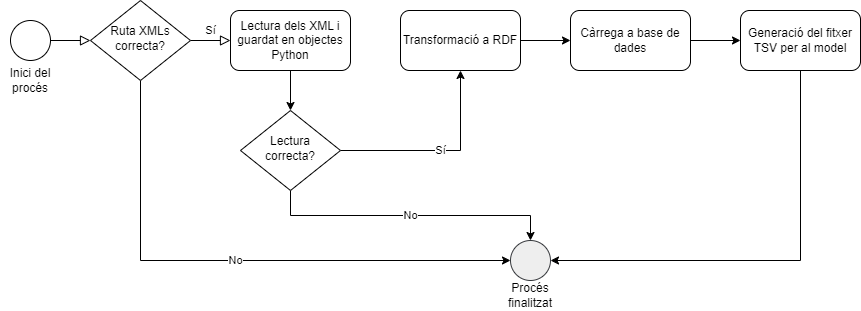

Els resultats d'aquest procés es guardaran a la carpeta definida en la variable PATH_RESULTS. Aquests resultats són:
* Carpeta 'rdf' amb tots els estudis clínics amb format RDF.
* Fitxer 'clinical_trials.tsv' amb la informació sobre els estudis clínics que s'utilitzarà durant la implementació del model.

In [9]:
API_URL = "http://127.0.0.1:5000/tfm-collaboration-network/v1/NetworkCollaboration/insert"
PATH_RESULTS = "../../results"

headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}

params = {
    "folder_xml_path": os.path.abspath(PATH_DESTINATION),
    "folder_results": os.path.abspath(PATH_RESULTS),
    "insert_database": False
}

r=requests.post(url = API_URL, headers = headers, json = params)

print("Response: " + r.json()['message'])

Response: ['The save of XMLs information has ended successfully.', 'Process to transform to RDF ended', 'The transformation process to TSV has ended successfully.', 'The transformation process has ended successfully.']


<div class="alert alert-block alert-warning">
Els resultats d'aquest procés es troben a la carpeta del GitHub anomenada <a href="https://github.com/mfontsanc/TFM_CienciaDades/tree/main/results">results</a>.
</div>